# Prepare velocity model

Use this notebook to prepare a velocity model as input of the notebook "Velocity_to_poly_nnl", by doing the necessary interpolations  
This notebook might require some adjustments depending on the input velocity model used:  
* step 1: read and convert velocity to xarray dataset
* step 2: vertical extrapolation to have all depth for the available grid points (nearest neighbor interpolation)
* step 3: horizontal interpolation 'cubic' by depth slice to fill gaps
* step 4: save to netcdf

In [1]:
import numpy as np
import pandas as pd
import pygmt
from pyproj import CRS, Transformer
import matplotlib.pyplot as plt
from scipy import interpolate
import xarray as xr
import os

In [2]:
file_path = "../locations/Delphetal2018_1.75VpVs.txt"
df = pd.read_csv(file_path, sep=r'\s+', header=None, names=['lon', 'lat', 'depth', 'Vp', 'Vs'])

# Pivot the DataFrame to get the multi-dimensional array structure
df_pivot = df.pivot_table(index=['lat', 'lon', 'depth'], values=['Vp', 'Vs'])

# Convert the pivoted DataFrame to an xarray Dataset
ds = xr.Dataset.from_dataframe(df_pivot).sel(depth=slice(-4, 100)).reindex({"depth": range(-4, 101)})
ds

<xarray.Dataset> Size: 7MB
Dimensions:  (lat: 68, lon: 65, depth: 105)
Coordinates:
  * lat      (lat) float64 544B 36.0 36.2 36.4 36.6 36.8 ... 48.8 49.0 49.2 49.4
  * lon      (lon) float64 520B -124.8 -124.6 -124.4 ... -112.4 -112.2 -112.0
  * depth    (depth) int64 840B -4 -3 -2 -1 0 1 2 3 ... 93 94 95 96 97 98 99 100
Data variables:
    Vp       (lat, lon, depth) float64 4MB nan nan nan nan ... nan nan nan nan
    Vs       (lat, lon, depth) float64 4MB nan nan nan nan ... nan nan nan nan

# vertical interpolation to get velocity between 100km depth and -4km

In [3]:
ds_interp = ds.interpolate_na(dim="depth", method="nearest", fill_value="extrapolate")
ds_interp

<xarray.Dataset> Size: 7MB
Dimensions:  (lat: 68, lon: 65, depth: 105)
Coordinates:
  * lat      (lat) float64 544B 36.0 36.2 36.4 36.6 36.8 ... 48.8 49.0 49.2 49.4
  * lon      (lon) float64 520B -124.8 -124.6 -124.4 ... -112.4 -112.2 -112.0
  * depth    (depth) int64 840B -4 -3 -2 -1 0 1 2 3 ... 93 94 95 96 97 98 99 100
Data variables:
    Vp       (lat, lon, depth) float64 4MB nan nan nan nan ... nan nan nan nan
    Vs       (lat, lon, depth) float64 4MB nan nan nan nan ... nan nan nan nan

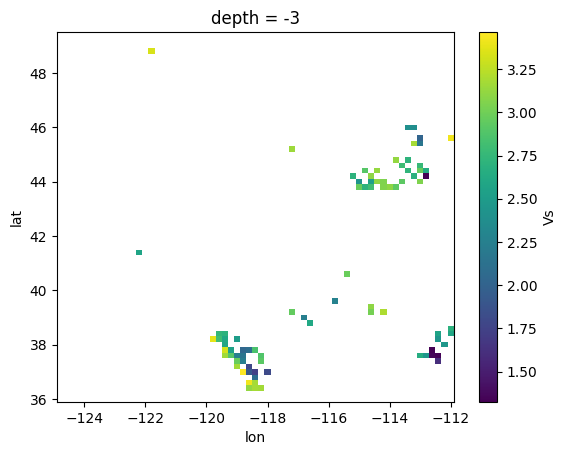

In [4]:
ds.sel(depth=-3).Vs.plot()

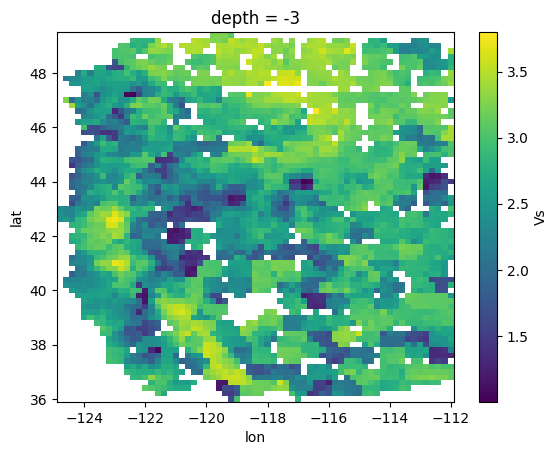

In [5]:
ds_interp.sel(depth=-3).Vs.plot()

# Interpolation by depth slice to fill gaps

In [6]:
def interp_depth_slice(depth_data, lon, lat, method='cubic'):
    """
    Interpolates missing data for a specific depth using scipy's griddata.

    Parameters:
    depth_data (np.array): 2D array of data at a specific depth.
    lon (np.array): 1D array of longitudes.
    lat (np.array): 1D array of latitudes.
    method (str): Interpolation method (default is 'cubic').

    Returns:
    np.array: 2D array of interpolated data.
    """
    lon_grid, lat_grid = np.meshgrid(lon, lat)
    
    # Mask to get the valid data points
    mask = ~np.isnan(depth_data)
    
    # Coordinates of the valid data points
    points = np.column_stack((lon_grid[mask], lat_grid[mask]))
    
    # Values of the valid data points
    values = depth_data[mask]
    
    # Coordinates for the entire grid
    grid_points = np.column_stack((lon_grid.ravel(), lat_grid.ravel()))
    
    # Perform the interpolation
    interpolated_data = interpolate.griddata(points, values, grid_points, method=method)
    
    return interpolated_data.reshape(depth_data.shape)

def apply_interpolation(xr_data, method='cubic'):
    """
    Applies interpolation to an xarray DataArray along the depth dimension.

    Parameters:
    xr_data (xr.DataArray): xarray DataArray with dimensions (lon, lat, depth).
    method (str): Interpolation method (default is 'cubic').

    Returns:
    xr.DataArray: Interpolated xarray DataArray.
    """
    # Get the coordinates
    lon = xr_data['lon'].values
    lat = xr_data['lat'].values

    # Use xarray's apply_ufunc to apply the interpolation function to each depth slice
    interpolated = xr.apply_ufunc(
        interp_depth_slice,
        xr_data,
        input_core_dims=[['lat', 'lon']],
        output_core_dims=[['lat', 'lon']],
        vectorize=True,
        dask='parallelized',
        kwargs={'lon': lon, 'lat': lat, 'method': method}
    )
    
    return interpolated

In [7]:
ds_interp['Vs_interp'] = apply_interpolation(ds_interp.Vs, method='cubic')
ds_interp['Vp_interp'] = apply_interpolation(ds_interp.Vp, method='cubic')
ds_interp

<xarray.Dataset> Size: 15MB
Dimensions:    (lat: 68, lon: 65, depth: 105)
Coordinates:
  * lat        (lat) float64 544B 36.0 36.2 36.4 36.6 ... 48.8 49.0 49.2 49.4
  * lon        (lon) float64 520B -124.8 -124.6 -124.4 ... -112.4 -112.2 -112.0
  * depth      (depth) int64 840B -4 -3 -2 -1 0 1 2 3 ... 94 95 96 97 98 99 100
Data variables:
    Vp         (lat, lon, depth) float64 4MB nan nan nan nan ... nan nan nan nan
    Vs         (lat, lon, depth) float64 4MB nan nan nan nan ... nan nan nan nan
    Vs_interp  (depth, lat, lon) float64 4MB nan nan nan nan ... nan nan nan nan
    Vp_interp  (depth, lat, lon) float64 4MB nan nan nan nan ... nan nan nan nan

# verrification plots

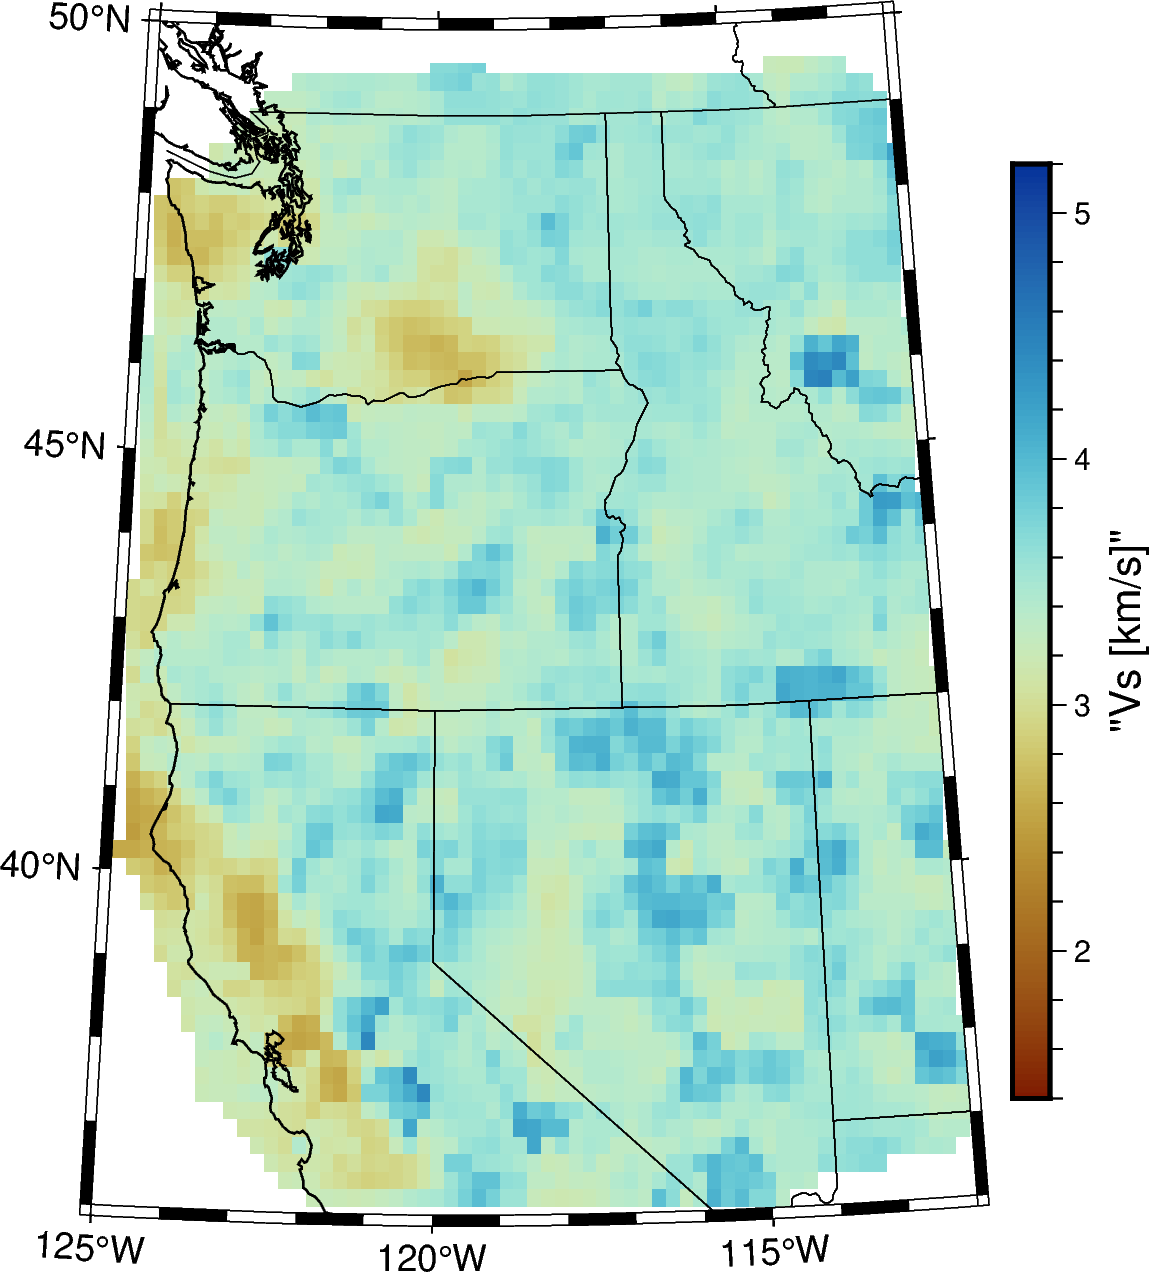

In [8]:
### Example PyGMT Map

# Depth for horizontal slice
depth = 5

# Setting variables related to the colorscale
vmin1 = 1.400
vmax1 = 5.200
vspace = 0.025
vs1_series = (vmin1, vmax1, vspace)
vs1_above = [vmax1,vmax1]
vs1_below = [vmin1,vmin1]

#Setting projection variables
projection = 'L-119.5/37.25/31.5/43/7.5c'
region = [-125,-112,36,50]

# map figure
fig = pygmt.Figure()

# make colormap
pygmt.makecpt(cmap="roma", series=vs1_series)

# Plot a 5km map view slice of the model in isotropic Vs
fig.grdimage(grid=pygmt.grdclip(ds_interp['Vs_interp'].interp(depth = depth, method = "linear"), 
                                below=vs1_below, above=vs1_above), projection=projection)
fig.colorbar(frame='af+l"Vs [km/s]"',position="JMR+o0.3c/0c")

# Coast
fig.coast(shorelines = '1/0.5p', region = region, projection=projection,
            frame = ['af'], borders=["1/black", "2/black"])

# stations
#fig.plot(x=sdf["lon"],y=sdf["lat"],style="t1p")

# origin
# fig.plot(x=olon,y=olat,style="c3p",fill="red")

# Show Results
fig.savefig("./velocity_depth5.png", dpi=300)
fig.show()

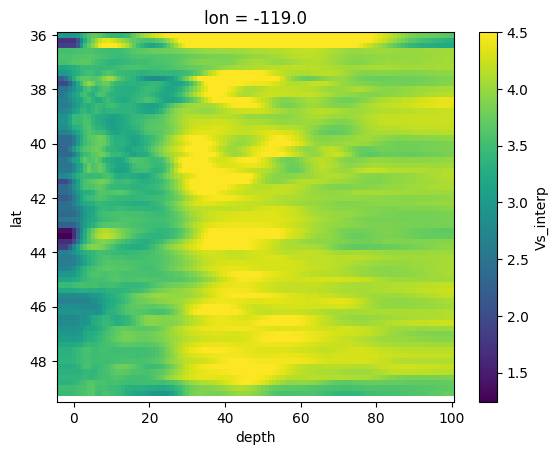

In [9]:
ds_interp.sel(lon=-119).Vs_interp.T.plot()
plt.gca().invert_yaxis()

# Save velocity model as netcdf

In [10]:
ds_interp.to_netcdf("../locations/velocity_interp_delph2018.nc")